### seismic data and fault display

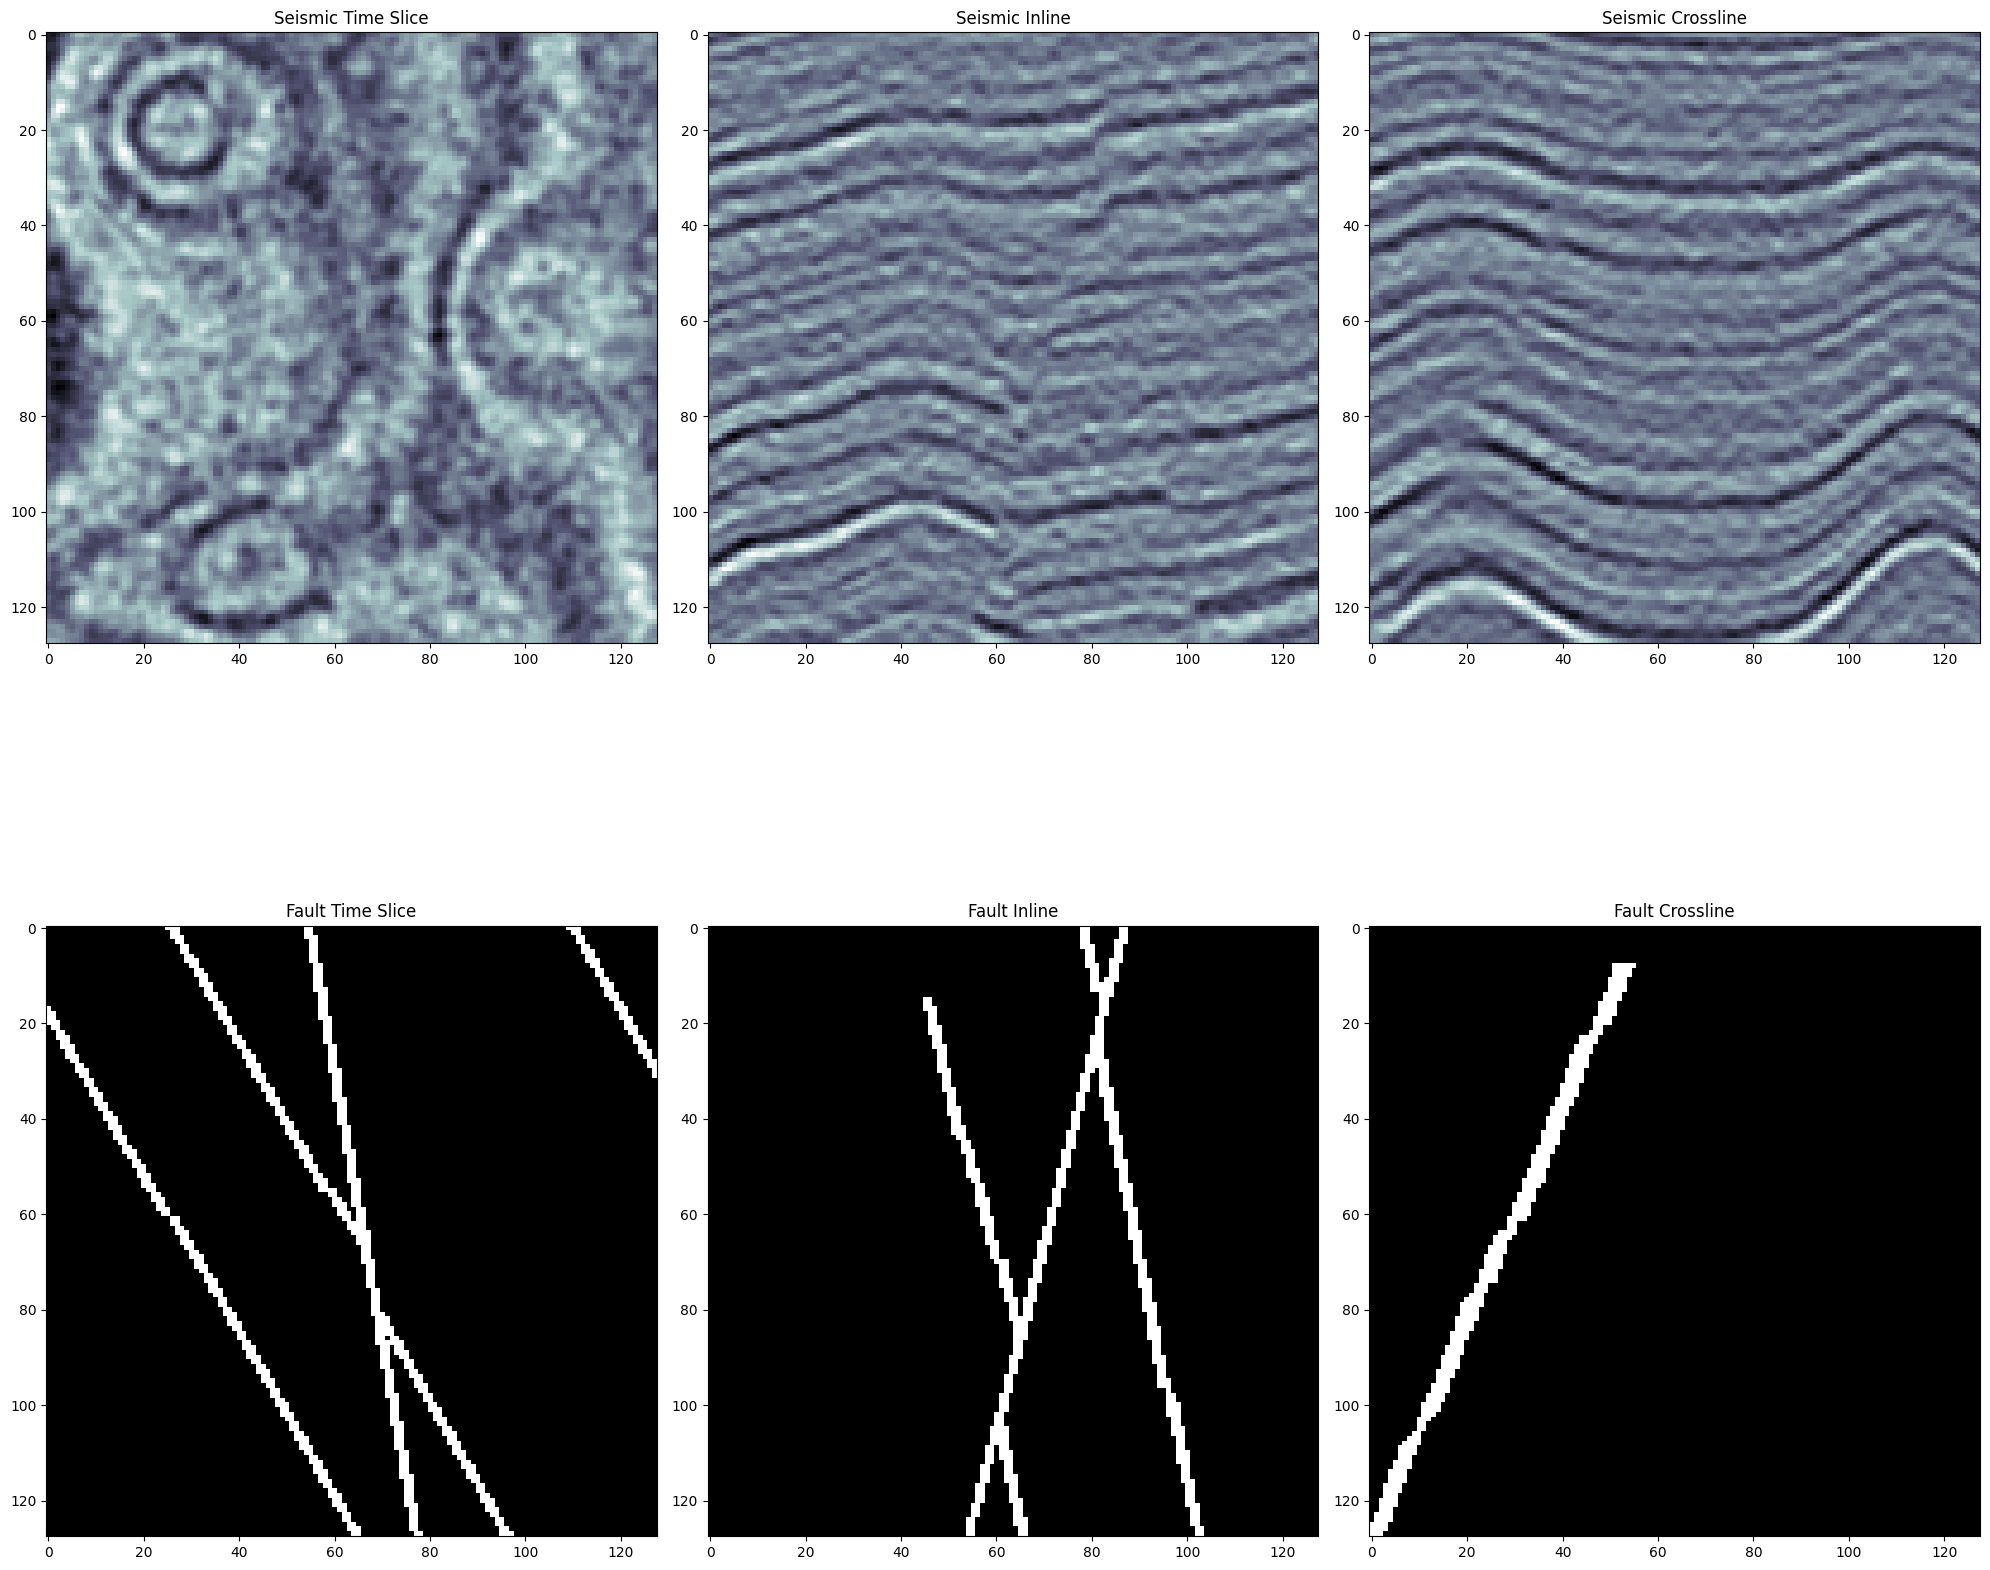

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os


seismPath = "./NCData/train/seis/"
faultPath = "./NCData/train/fault/"
n1,n2,n3 = 128,128,128
dk = 2

# Load and preprocess data
gx = np.fromfile(seismPath+str(dk)+'.dat', dtype=np.single)
fx = np.fromfile(faultPath+str(dk)+'.dat', dtype=np.single)
gx = np.reshape(gx, (n1,n2,n3))
fx = np.reshape(fx, (n1,n2,n3))

# Normalize seismic data
gm = np.mean(gx)
gs = np.std(gx)
gx = (gx-gm)/gs

# Transpose both arrays
gx = np.transpose(gx)


fx = np.transpose(fx)

fig = plt.figure(figsize=(20,20))

# Time slices
k1 = 50
plt.subplot(2, 3, 1)
plt.imshow(gx[k1,:,:], cmap=plt.cm.bone, interpolation='nearest', aspect=1)
plt.title('Seismic Time Slice')
plt.subplot(2, 3, 4)
plt.imshow(fx[k1,:,:], cmap=plt.cm.bone, interpolation='nearest', aspect=1)
plt.title('Fault Time Slice')

# Inline slices
k2 = 110
plt.subplot(2, 3, 2)
plt.imshow(gx[:,k2,:], cmap=plt.cm.bone, interpolation='nearest', aspect=1)
plt.title('Seismic Inline')
plt.subplot(2, 3, 5)
plt.imshow(fx[:,k2,:], cmap=plt.cm.bone, interpolation='nearest', aspect=1)
plt.title('Fault Inline')

# Crossline slices
k3 = 10
plt.subplot(2, 3, 3)
plt.imshow(gx[:,:,k3], cmap=plt.cm.bone, interpolation='nearest', aspect=1)
plt.title('Seismic Crossline')
plt.subplot(2, 3, 6)
plt.imshow(fx[:,:,k3], cmap=plt.cm.bone, interpolation='nearest', aspect=1)
plt.title('Fault Crossline')

plt.tight_layout()
plt.show()


### torch net

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()
            
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)

class DilatedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=4, dilation=4)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        out3 = self.conv3(x)
        return self.bn(out1 + out2 + out3)

class EnhancedUNet2D(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            ResidualBlock(1, 16),
            nn.Dropout2d(dropout_rate)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2 = nn.Sequential(
            ResidualBlock(16, 32),
            DilatedConvBlock(32, 32),
            nn.Dropout2d(dropout_rate)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3 = nn.Sequential(
            ResidualBlock(32, 64),
            DilatedConvBlock(64, 64),
            nn.Dropout2d(dropout_rate)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bridge = nn.Sequential(
            ResidualBlock(64, 128),
            DilatedConvBlock(128, 128),
            nn.Dropout2d(dropout_rate)
        )
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            ResidualBlock(128, 64),
            DilatedConvBlock(64, 64),
            nn.Dropout2d(dropout_rate)
        )
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            ResidualBlock(64, 32),
            DilatedConvBlock(32, 32),
            nn.Dropout2d(dropout_rate)
        )
        
        self.up3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            ResidualBlock(32, 16),
            nn.Dropout2d(dropout_rate)
        )
        
        # Deep supervision outputs
        self.deep_sup1 = nn.Conv2d(64, 1, kernel_size=1)
        self.deep_sup2 = nn.Conv2d(32, 1, kernel_size=1)
        self.final = nn.Conv2d(16, 1, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        pool1 = self.pool1(enc1)
        
        enc2 = self.enc2(pool1)
        pool2 = self.pool2(enc2)
        
        enc3 = self.enc3(pool2)
        pool3 = self.pool3(enc3)
        
        bridge = self.bridge(pool3)
        
        # Decoder with deep supervision
        up1 = self.up1(bridge)
        concat1 = torch.cat([up1, enc3], dim=1)
        dec1 = self.dec1(concat1)
        deep_out1 = self.deep_sup1(dec1)
        
        up2 = self.up2(dec1)
        concat2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.dec2(concat2)
        deep_out2 = self.deep_sup2(dec2)
        
        up3 = self.up3(dec2)
        concat3 = torch.cat([up3, enc1], dim=1)
        dec3 = self.dec3(concat3)
        
        final = self.final(dec3)
        
        if self.training:
            return torch.sigmoid(final), torch.sigmoid(deep_out1), torch.sigmoid(deep_out2)
        return torch.sigmoid(final)

def deep_supervision_loss(pred, deep1, deep2, target):
    main_loss = F.binary_cross_entropy(pred, target)
    aux_loss1 = F.binary_cross_entropy(F.interpolate(deep1, size=target.shape[2:]), target)
    aux_loss2 = F.binary_cross_entropy(F.interpolate(deep2, size=target.shape[2:]), target)
    return main_loss + 0.4 * aux_loss1 + 0.2 * aux_loss2

def test_model():
    # Create random input and target
    batch_size, height, width = 4, 128, 128
    x = torch.randn(batch_size, 1, height, width)
    y = torch.randint(0, 2, (batch_size, 1, height, width)).float()
    
    # Test model
    model = EnhancedUNet2D()
    
    # Test training mode (returns tuple of outputs)
    model.train()
    main_out, deep1, deep2 = model(x)
    print(f"Training mode shapes:")
    print(f"Main output: {main_out.shape}")
    print(f"Deep supervision 1: {deep1.shape}")
    print(f"Deep supervision 2: {deep2.shape}")
    
    loss = deep_supervision_loss(main_out, deep1, deep2, y)
    print(f"Training loss: {loss.item()}\n")
    
    # Test inference mode (returns single output)
    model.eval()
    with torch.no_grad():
        infer_out = model(x)
    print(f"Inference mode shape: {infer_out.shape}")

if __name__ == '__main__':
    test_model()

Training mode shapes:
Main output: torch.Size([4, 1, 128, 128])
Deep supervision 1: torch.Size([4, 1, 32, 32])
Deep supervision 2: torch.Size([4, 1, 64, 64])
Training loss: 1.2385531663894653

Inference mode shape: torch.Size([4, 1, 128, 128])


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()
            
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)

class DilatedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=4, dilation=4)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        out3 = self.conv3(x)
        return self.bn(out1 + out2 + out3)

class EnhancedUNet2D(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            ResidualBlock(1, 16),
            nn.Dropout2d(dropout_rate)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2 = nn.Sequential(
            ResidualBlock(16, 32),
            DilatedConvBlock(32, 32),
            nn.Dropout2d(dropout_rate)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3 = nn.Sequential(
            ResidualBlock(32, 64),
            DilatedConvBlock(64, 64),
            nn.Dropout2d(dropout_rate)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bridge = nn.Sequential(
            ResidualBlock(64, 128),
            DilatedConvBlock(128, 128),
            nn.Dropout2d(dropout_rate)
        )
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            ResidualBlock(128, 64),
            DilatedConvBlock(64, 64),
            nn.Dropout2d(dropout_rate)
        )
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            ResidualBlock(64, 32),
            DilatedConvBlock(32, 32),
            nn.Dropout2d(dropout_rate)
        )
        
        self.up3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            ResidualBlock(32, 16),
            nn.Dropout2d(dropout_rate)
        )
        
        # Deep supervision outputs
        self.deep_sup1 = nn.Conv2d(64, 1, kernel_size=1)
        self.deep_sup2 = nn.Conv2d(32, 1, kernel_size=1)
        self.final = nn.Conv2d(16, 1, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        pool1 = self.pool1(enc1)
        
        enc2 = self.enc2(pool1)
        pool2 = self.pool2(enc2)
        
        enc3 = self.enc3(pool2)
        pool3 = self.pool3(enc3)
        
        bridge = self.bridge(pool3)
        
        # Decoder with deep supervision
        up1 = self.up1(bridge)
        concat1 = torch.cat([up1, enc3], dim=1)
        dec1 = self.dec1(concat1)
        deep_out1 = self.deep_sup1(dec1)
        
        up2 = self.up2(dec1)
        concat2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.dec2(concat2)
        deep_out2 = self.deep_sup2(dec2)
        
        up3 = self.up3(dec2)
        concat3 = torch.cat([up3, enc1], dim=1)
        dec3 = self.dec3(concat3)
        
        final = self.final(dec3)
        
        if self.training:
            return torch.sigmoid(final), torch.sigmoid(deep_out1), torch.sigmoid(deep_out2)
        return torch.sigmoid(final)

def deep_supervision_loss(pred, deep1, deep2, target):
    main_loss = F.binary_cross_entropy(pred, target)
    aux_loss1 = F.binary_cross_entropy(F.interpolate(deep1, size=target.shape[2:]), target)
    aux_loss2 = F.binary_cross_entropy(F.interpolate(deep2, size=target.shape[2:]), target)
    return main_loss + 0.4 * aux_loss1 + 0.2 * aux_loss2

def test_model():
    # Create random input and target
    batch_size, height, width = 4, 128, 128
    x = torch.randn(batch_size, 1, height, width)
    y = torch.randint(0, 2, (batch_size, 1, height, width)).float()
    
    # Test model
    model = EnhancedUNet2D()
    
    # Test training mode (returns tuple of outputs)
    model.train()
    main_out, deep1, deep2 = model(x)
    print(f"Training mode shapes:")
    print(f"Main output: {main_out.shape}")
    print(f"Deep supervision 1: {deep1.shape}")
    print(f"Deep supervision 2: {deep2.shape}")
    
    loss = deep_supervision_loss(main_out, deep1, deep2, y)
    print(f"Training loss: {loss.item()}\n")
    
    # Test inference mode (returns single output)
    model.eval()
    with torch.no_grad():
        infer_out = model(x)
    print(f"Inference mode shape: {infer_out.shape}")

if __name__ == '__main__':
    test_model()

Training mode shapes:
Main output: torch.Size([4, 1, 128, 128])
Deep supervision 1: torch.Size([4, 1, 32, 32])
Deep supervision 2: torch.Size([4, 1, 64, 64])
Training loss: 1.1742088794708252

Inference mode shape: torch.Size([4, 1, 128, 128])


### Training script

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import random
from datetime import datetime

def visualize_results(model, valid_loader, device, save_dir='validation_results', num_samples=5):
    """
    Visualize and save validation results with 90-degree clockwise rotation.
    
    Args:
        model: trained model
        valid_loader: validation data loader
        device: torch device
        save_dir: directory to save results
        num_samples: number of samples to visualize
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'binary'), exist_ok=True)
    
    # Set model to evaluation mode
    model.eval()
    
    # Create timestamp for unique filenames
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    with torch.no_grad():
        for i, (seismic, fault) in enumerate(valid_loader):
            if i >= num_samples:
                break
                
            # Move data to device
            seismic = seismic.to(device)
            fault = fault.to(device)
            
            # Get model predictions
            outputs = model(seismic)
            if isinstance(outputs, tuple):
                # If using deep supervision, take main output
                pred = outputs[0]
            else:
                pred = outputs
            
            # Convert predictions to binary using threshold
            pred_binary = (pred > 0.5).float()
            
            # Rotate 90 degrees clockwise
            seismic_rotated = torch.rot90(seismic[0, 0], k=-1, dims=[0, 1])  # k=-1 for clockwise
            fault_rotated = torch.rot90(fault[0, 0], k=-1, dims=[0, 1])
            pred_rotated = torch.rot90(pred_binary[0, 0], k=-1, dims=[0, 1])
            
            # Create figure with three subplots
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Plot rotated seismic data
            seismic_plot = axes[0].imshow(seismic_rotated.cpu().numpy(), cmap='seismic')
            axes[0].set_title('Seismic Data')
            plt.colorbar(seismic_plot, ax=axes[0])
            
            # Plot rotated ground truth faults
            fault_plot = axes[1].imshow(fault_rotated.cpu().numpy(), cmap='viridis')
            axes[1].set_title('Ground Truth Faults')
            plt.colorbar(fault_plot, ax=axes[1])
            
            # Plot rotated model predictions
            pred_plot = axes[2].imshow(pred_rotated.cpu().numpy(), cmap='viridis')
            axes[2].set_title('Model Predictions')
            plt.colorbar(pred_plot, ax=axes[2])
            
            # Add overall title
            plt.suptitle(f'Validation Sample {i+1} (90° Clockwise Rotation)')
            
            # Adjust layout
            plt.tight_layout()
            
            # Save visualization figure
            save_path = os.path.join(save_dir, f'validation_result_{timestamp}_sample_{i+1}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            # Save binary predictions and ground truth
            binary_save_dir = os.path.join(save_dir, 'binary')
            
            # Save ground truth
            fault_save_path = os.path.join(binary_save_dir, f'ground_truth_{timestamp}_sample_{i+1}.npy')
            np.save(fault_save_path, fault_rotated.cpu().numpy())
            
            # Save predictions
            pred_save_path = os.path.join(binary_save_dir, f'prediction_{timestamp}_sample_{i+1}.npy')
            np.save(pred_save_path, pred_rotated.cpu().numpy())

def plot_metrics(train_losses, val_losses, train_accs, val_accs, save_dir='validation_results'):
    """
    Plot training and validation metrics.
    
    Args:
        train_losses: list of training losses
        val_losses: list of validation losses
        train_accs: list of training accuracies
        val_accs: list of validation accuracies
        save_dir: directory to save results
    """
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Adjust layout and save
    plt.tight_layout()
    save_path = os.path.join(save_dir, f'training_metrics_{timestamp}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


# Move set_seed function definition outside of any other function
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class SeismicDataset2D(Dataset):
    def __init__(self, seism_path, fault_path, data_ids, dim=(128,128,128)):
        self.seism_path = seism_path
        self.fault_path = fault_path
        self.data_ids = data_ids
        self.dim = dim
        self.slices_per_volume = dim[0]
        
    def __len__(self):
        return len(self.data_ids) * self.slices_per_volume

    def __getitem__(self, idx):
        volume_idx = idx // self.slices_per_volume
        slice_idx = idx % self.slices_per_volume
        
        seismic_file = os.path.join(self.seism_path, f"{self.data_ids[volume_idx]}.dat")
        fault_file = os.path.join(self.fault_path, f"{self.data_ids[volume_idx]}.dat")

        seismic = np.fromfile(seismic_file, dtype=np.single)
        fault = np.fromfile(fault_file, dtype=np.single)

        seismic = np.reshape(seismic, self.dim)
        fault = np.reshape(fault, self.dim)

        seismic_slice = seismic[slice_idx, :, :]
        fault_slice = fault[slice_idx, :, :]

        seismic_slice = seismic_slice - np.min(seismic_slice)
        seismic_slice = seismic_slice / (np.max(seismic_slice) + 1e-8)
        seismic_slice = seismic_slice * 255

        seismic_slice = torch.from_numpy(seismic_slice).float().unsqueeze(0)
        fault_slice = torch.from_numpy(fault_slice).float().unsqueeze(0)

        return seismic_slice, fault_slice

def train_model_2d():
    # Set random seeds for reproducibility
    seed_val = 12345
    set_seed(seed_val)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Parameters
    batch_size = 32
    dim = (128, 128, 128)
    
    # Paths
    seism_path_train = "NCData/train/seis"
    fault_path_train = "NCData/train/fault"
    seism_path_val = "NCData/validation/seis"
    fault_path_val = "NCData/validation/fault"

    # Create datasets
    train_ids = list(range(200))  # Convert range to list
    valid_ids = list(range(20))   # Convert range to list

    train_dataset = SeismicDataset2D(seism_path_train, fault_path_train, 
                                   train_ids, dim=dim)
    valid_dataset = SeismicDataset2D(seism_path_val, fault_path_val, 
                                   valid_ids, dim=dim)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # Setup device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model and move it to device
    model = EnhancedUNet2D()
    # model = ImprovedSeismicUNet()
    model = model.to(device)
    
    # Initialize optimizer after moving model to device
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Initialize TensorBoard writer
    writer = SummaryWriter('./log1')
    Path('check1').mkdir(exist_ok=True)

    num_epochs = 10
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch_idx, (seismic, fault) in enumerate(train_loader):
            seismic = seismic.to(device, non_blocking=True)
            fault = fault.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            try:
                outputs = model(seismic)
                main_out, deep1, deep2 = outputs
                # loss = seismic_loss(main_out, deep1, deep2, fault)
                loss = deep_supervision_loss(main_out, deep1, deep2, fault)
                
                loss.backward()
                optimizer.step()
                
            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                print(f"Seismic device: {seismic.device}")
                print(f"Fault device: {fault.device}")
                print(f"Model device: {next(model.parameters()).device}")
                raise e
            
            # Calculate metrics
            with torch.no_grad():
                train_loss += loss.item()
                pred = (main_out > 0.5).float()
                train_acc += (pred == fault).float().mean().item()
            
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx}/{len(train_loader)} '
                    f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                    f'Loss: {loss.item():.6f}')
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for seismic, fault in valid_loader:
                seismic = seismic.to(device, non_blocking=True)
                fault = fault.to(device, non_blocking=True)
                
                output = model(seismic)
                val_loss += F.binary_cross_entropy(output, fault).item()
                pred = (output > 0.5).float()
                val_acc += (pred == fault).float().mean().item()
        
        val_loss /= len(valid_loader)
        val_acc /= len(valid_loader)
        
        # Log metrics
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/validation', val_acc, epoch)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, f'check1/fseg-best.pth')
        
        # Save periodic checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, f'check1/fseg-{epoch:02d}.pth')
        # Store metrics

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Visualize results periodically
        if (epoch + 1) % 2 == 0:
            visualize_results(model, valid_loader, device)
            plot_metrics(train_losses, val_losses, train_accs, val_accs)
            
    writer.close()
    torch.save(model.state_dict(), 'check1/fseg-final.pth')

if __name__ == '__main__':
    train_model_2d()

Using device: mps
Train Epoch: 0 [0/800 (0%)]	Loss: 1.390844
Train Epoch: 0 [100/800 (12%)]	Loss: 1.042311
Train Epoch: 0 [200/800 (25%)]	Loss: 0.931722
Train Epoch: 0 [300/800 (38%)]	Loss: 0.907924
Train Epoch: 0 [400/800 (50%)]	Loss: 0.825435
Train Epoch: 0 [500/800 (62%)]	Loss: 0.805442
Train Epoch: 0 [600/800 (75%)]	Loss: 0.759354
Train Epoch: 0 [700/800 (88%)]	Loss: 0.715803
Epoch 1/10:
Train Loss: 0.8748, Train Acc: 0.8484
Val Loss: 0.3323, Val Acc: 0.9277
Train Epoch: 1 [0/800 (0%)]	Loss: 0.695982
Train Epoch: 1 [100/800 (12%)]	Loss: 0.676728
Train Epoch: 1 [200/800 (25%)]	Loss: 0.607662
Train Epoch: 1 [300/800 (38%)]	Loss: 0.605222
Train Epoch: 1 [400/800 (50%)]	Loss: 0.535465
Train Epoch: 1 [500/800 (62%)]	Loss: 0.532060
Train Epoch: 1 [600/800 (75%)]	Loss: 0.486212
Train Epoch: 1 [700/800 (88%)]	Loss: 0.468492
Epoch 2/10:
Train Loss: 0.5559, Train Acc: 0.9287
Val Loss: 0.2222, Val Acc: 0.9385
Train Epoch: 2 [0/800 (0%)]	Loss: 0.423326
Train Epoch: 2 [100/800 (12%)]	Loss: 0.40

KeyboardInterrupt: 

### Prediction script

In [60]:
import torch
import numpy as np
# from unet2d import UNet2D

def get_mask(n1, n2, os):
    sc = np.ones((n1, n2), dtype=np.single)
    sp = np.zeros(os, dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)
    
    for k1 in range(os):
        for k2 in range(n2):
            sc[k1][k2] = sp[k1]
            sc[n1-k1-1][k2] = sp[k1]
    
    for k1 in range(n1):
        for k2 in range(os):
            sc[k1][k2] = sp[k2]
            sc[k1][n2-k2-1] = sp[k2]
    
    return sc

def save_prediction(data, save_path="data/prediction/f3d/fp.dat"):
    # Create full directory path if it doesn't exist
    save_dir = os.path.dirname(save_path)
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Save the data
    try:
        data.tofile(save_path)
        print(f"Successfully saved prediction to {save_path}")
    except Exception as e:
        print(f"Error saving file: {e}")
        # Try alternative location if original fails
        alt_path = os.path.join(os.getcwd(), "predictions.dat")
        print(f"Attempting to save to alternative location: {alt_path}")
        data.tofile(alt_path)
        print(f"Saved to alternative location: {alt_path}")

def predict_faults():
    # Setup device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    # Load model
    # model = UNet2D().to(device)
    model = EnhancedUNet2D().to(device)
    checkpoint = torch.load('check1/fseg-final.pth')
    model.load_state_dict(checkpoint)
    model.eval()

    # Parameters
    n1, n2 = 128, 128  # training dimensions (2D)
    os = 12  # overlap width

    # Load seismic data
    gx = np.fromfile("NCData/prediction/f3d/gxl.dat", dtype=np.single)
    m1, m2, m3 = 512, 384, 128  # original dimensions
    gx = np.reshape(gx, (m1, m2, m3))

    # Calculate padding dimensions for 2D slices
    c1 = int(np.round((m1+os)/(n1-os)+0.5))
    c2 = int(np.round((m2+os)/(n2-os)+0.5))
    
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os

    # Initialize output array
    gy = np.zeros((m1, m2, m3), dtype=np.single)

    # Get 2D overlap mask
    sc = get_mask(n1, n2, os)

    # Process each depth slice
    with torch.no_grad():
        for z in range(m3):
            # Initialize arrays for this slice
            gp = np.zeros((p1, p2), dtype=np.single)
            slice_pred = np.zeros((p1, p2), dtype=np.single)
            mk = np.zeros((p1, p2), dtype=np.single)
            
            # Copy original slice data
            gp[0:m1, 0:m2] = gx[:, :, z]
            
            # Predict in patches for this slice
            for k1 in range(c1):
                for k2 in range(c2):
                    # Calculate patch coordinates
                    b1 = k1*n1-k1*os
                    e1 = b1+n1
                    b2 = k2*n2-k2*os
                    e2 = b2+n2

                    # Extract and normalize patch
                    patch = gp[b1:e1, b2:e2]
                    patch = patch - np.min(patch)
                    patch = patch / (np.max(patch) + 1e-8)
                    patch = patch * 255

                    # Convert to torch tensor
                    patch = torch.from_numpy(patch).float()
                    patch = patch.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
                    patch = patch.to(device)

                    # Predict
                    output = model(patch)
                    output = output.cpu().numpy()[0, 0]  # Remove batch and channel dims

                    # Accumulate predictions and mask
                    slice_pred[b1:e1, b2:e2] += output * sc
                    mk[b1:e1, b2:e2] += sc

            # Average predictions for this slice
            slice_pred = slice_pred / (mk + 1e-8)
            
            # Store in final output
            gy[:, :, z] = slice_pred[0:m1, 0:m2]

            if z % 10 == 0:
                print(f"Processed slice {z}/{m3}")

    # Save predictions
    save_prediction(gy, save_path="data/prediction/f3d/fp.dat")
    print("Prediction completed and saved.")

if __name__ == '__main__':
    predict_faults()

Using device: mps
Processed slice 0/128
Processed slice 10/128
Processed slice 20/128
Processed slice 30/128
Processed slice 40/128
Processed slice 50/128
Processed slice 60/128
Processed slice 70/128
Processed slice 80/128
Processed slice 90/128
Processed slice 100/128
Processed slice 110/128
Processed slice 120/128
Successfully saved prediction to data/prediction/f3d/fp.dat
Prediction completed and saved.


### predictions visualizations

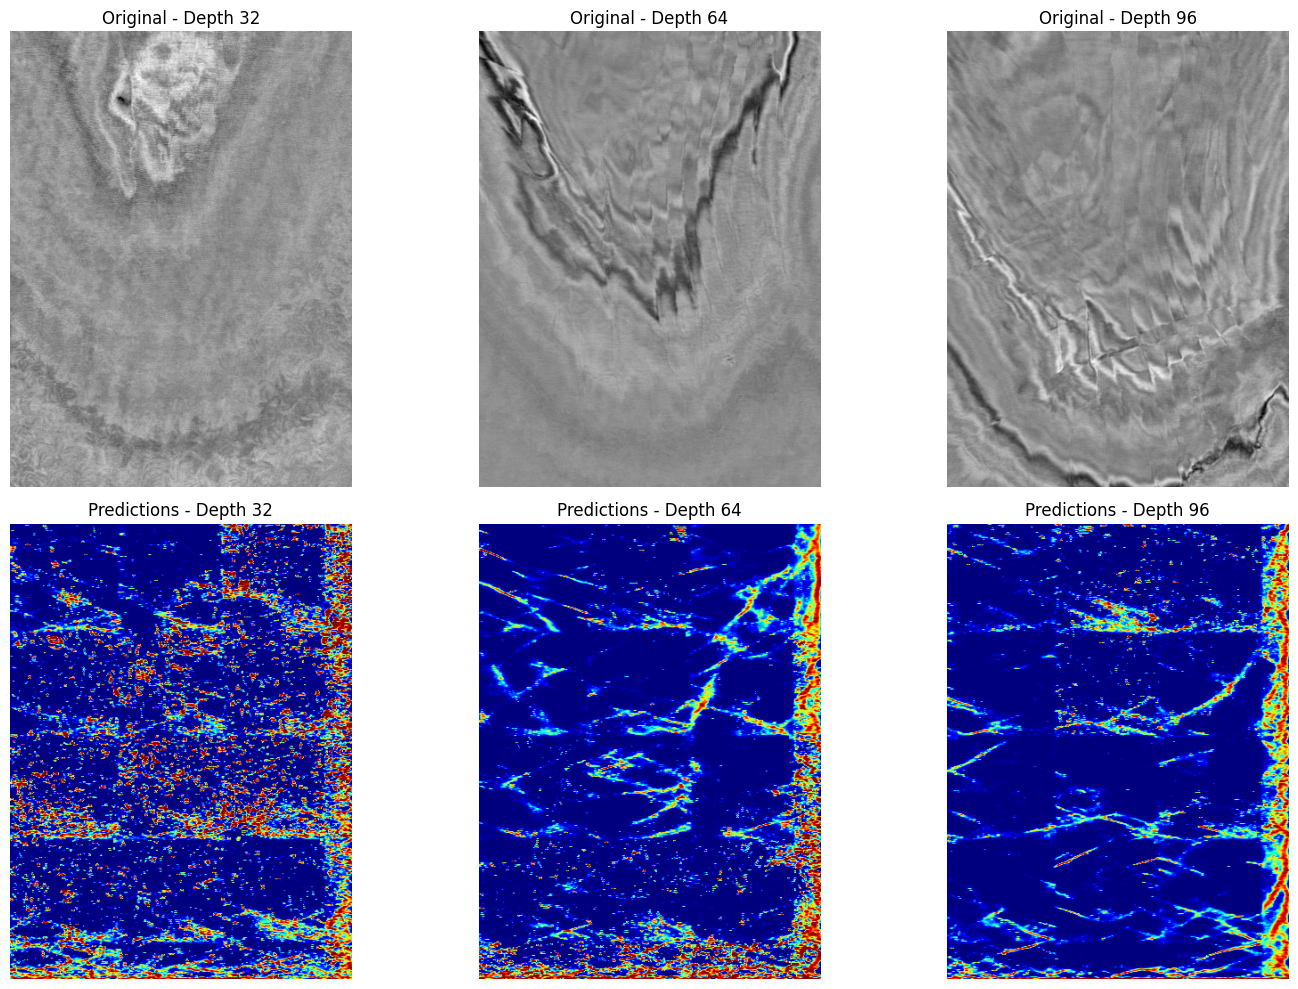

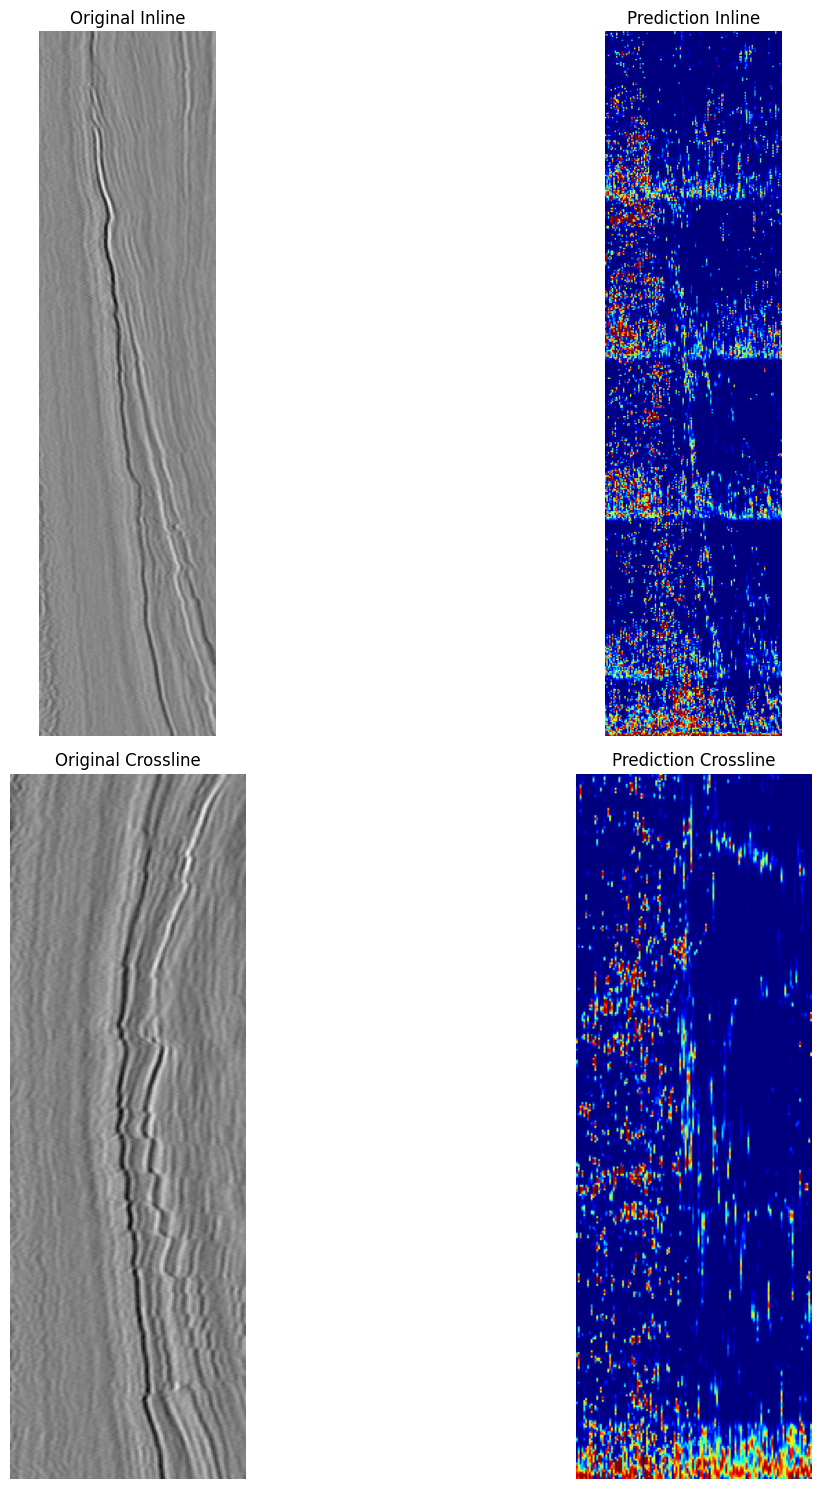

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(pred_path="data/prediction/f3d/fp.dat", original_path="NCData/prediction/f3d/gxl.dat"):
    # Load predictions and original data
    try:
        pred = np.fromfile(pred_path, dtype=np.single)
        orig = np.fromfile(original_path, dtype=np.single)
        
        # Reshape to 3D
        m1, m2, m3 = 512, 384, 128
        pred = np.reshape(pred, (m1, m2, m3))
        orig = np.reshape(orig, (m1, m2, m3))
        
        # Create figure with multiple slices
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Show three different depth slices
        depths = [m3//4, m3//2, 3*m3//4]
        
        for i, depth in enumerate(depths):
            # Original data
            axes[0, i].imshow(orig[:, :, depth], cmap='gray')
            axes[0, i].set_title(f'Original - Depth {depth}')
            axes[0, i].axis('off')
            
            # Predictions
            axes[1, i].imshow(pred[:, :, depth], cmap='jet')
            axes[1, i].set_title(f'Predictions - Depth {depth}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        
        # Save visualization
        save_dir = os.path.dirname(pred_path)
        plt.savefig(os.path.join(save_dir, 'visualization.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Also show some cross-sections
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        
        # Inline sections
        axes[0, 0].imshow(orig[:, m2//2, :], cmap='gray')
        axes[0, 0].set_title('Original Inline')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(pred[:, m2//2, :], cmap='jet')
        axes[0, 1].set_title('Prediction Inline')
        axes[0, 1].axis('off')
        
        # Crossline sections
        axes[1, 0].imshow(orig[m1//2, :, :], cmap='gray')
        axes[1, 0].set_title('Original Crossline')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(pred[m1//2, :, :], cmap='jet')
        axes[1, 1].set_title('Prediction Crossline')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'cross_sections.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error visualizing predictions: {e}")

if __name__ == '__main__':
    visualize_predictions()